<a href="https://colab.research.google.com/github/ta1231/ML_Practice/blob/main/TurboFan_Boosting_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV

In [2]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [3]:
from google.colab import drive
train=pd.read_csv("/content/train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("/content/test_FD001.txt",sep=" ",names=columns)
test_results=pd.read_csv("/content/RUL_FD001.txt",sep=" ",header=None)

In [4]:
train.head(10)

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,NaN,NaN
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,NaN,NaN
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,NaN,NaN
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,NaN,NaN
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,NaN,NaN


Text(0.5, 1.0, 'Engine LifeTime')

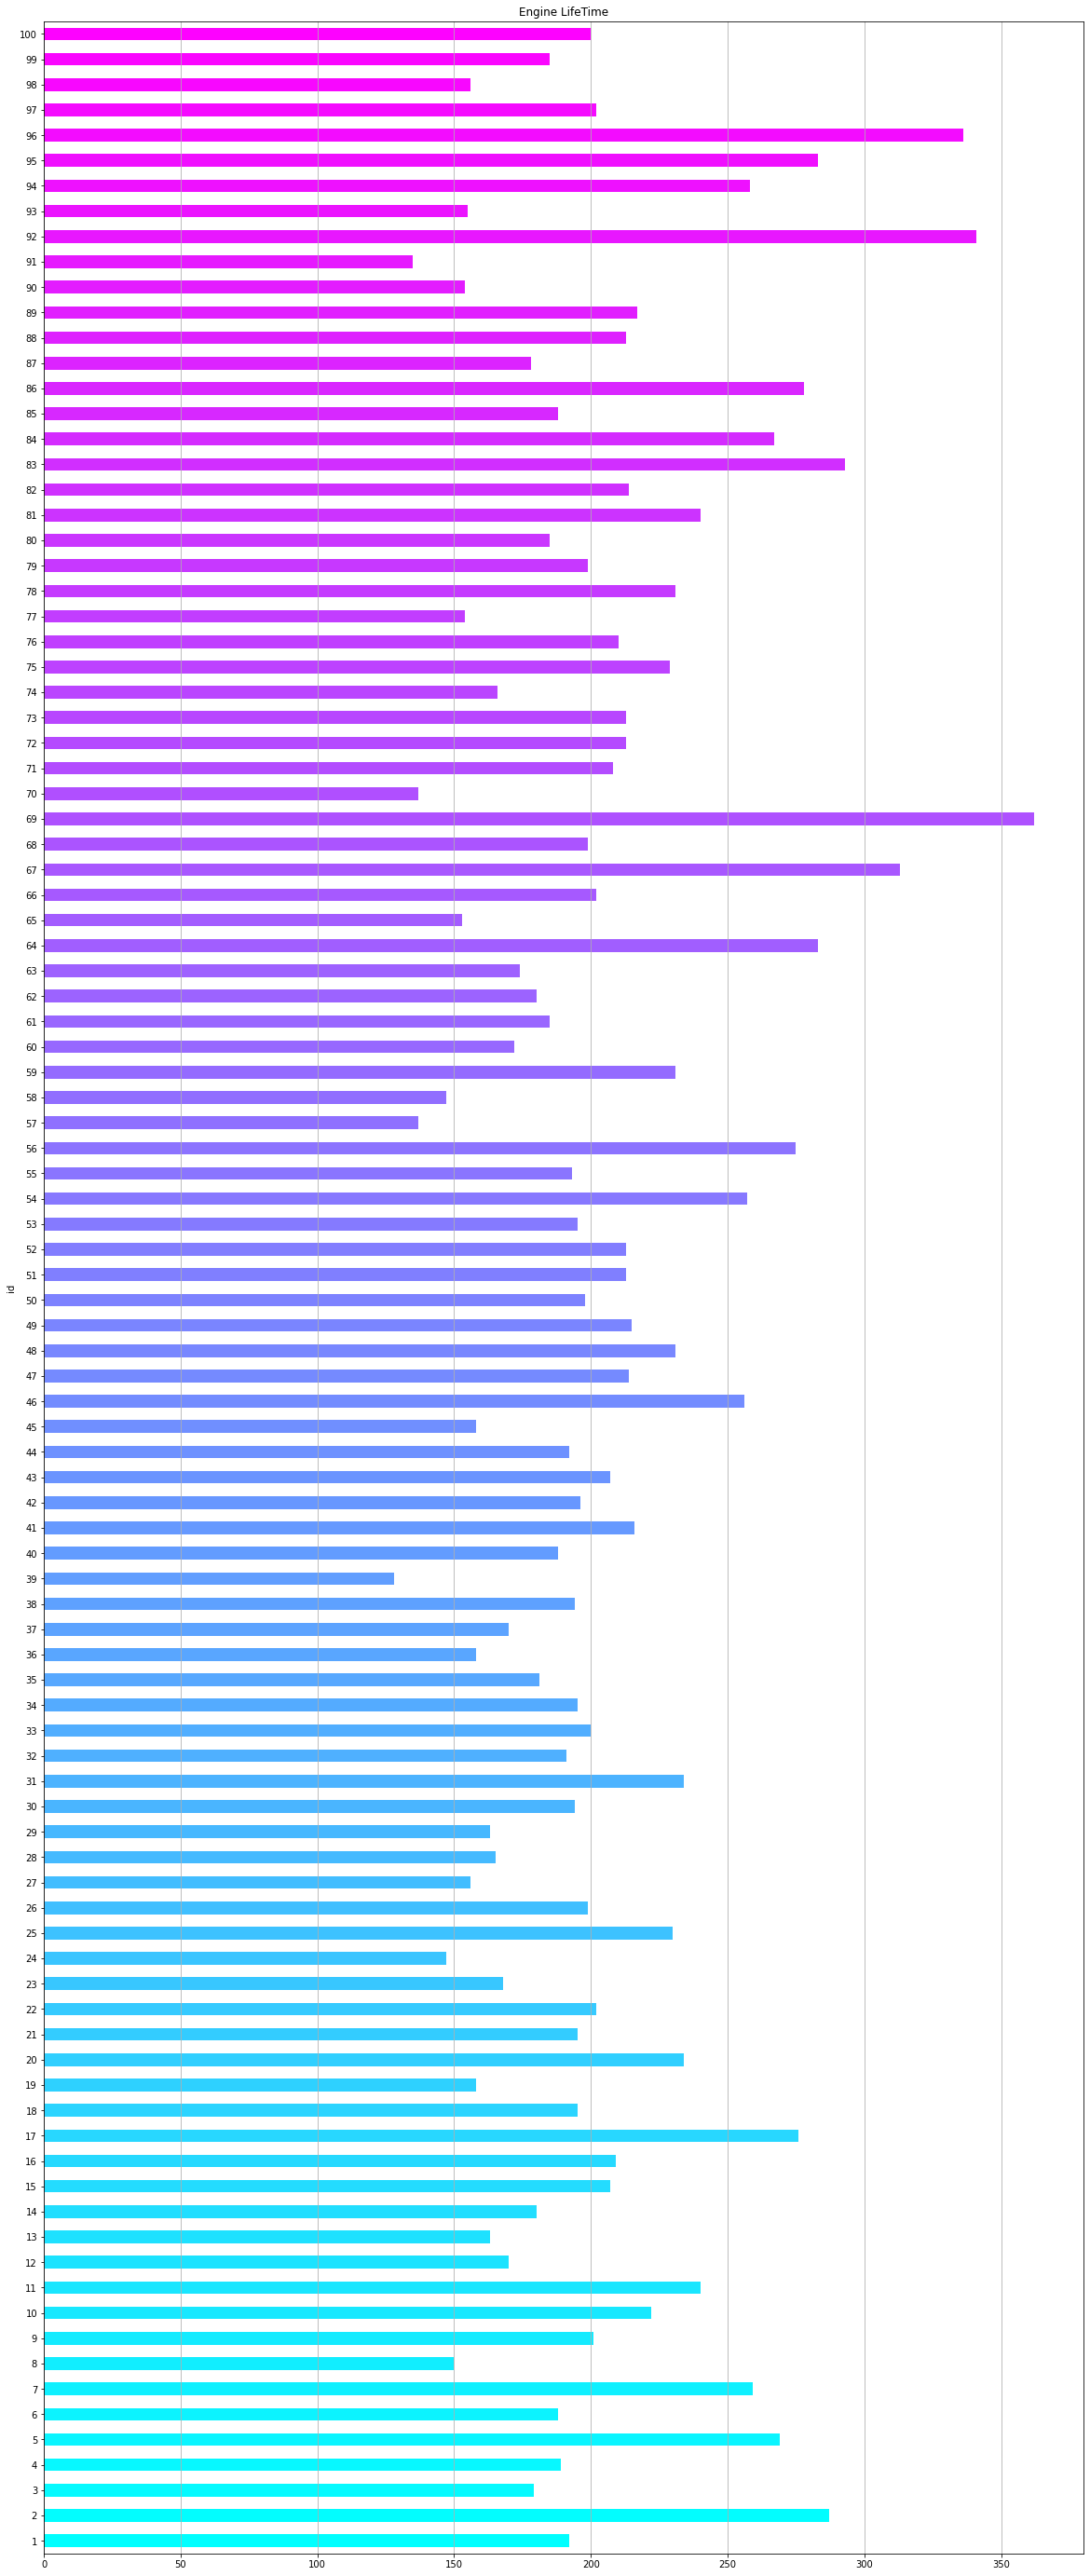

In [5]:
import matplotlib.cm as cm
colors = [plt.cm.cool(i/100) for i in range(100)]

plt.figure(figsize=(20, 50))
# select max(cycle) from train group by id;
ax = train.groupby('id')['cycle'].max().plot(kind = 'barh', color = colors)
ax.grid(axis='x')
plt.title('Engine LifeTime')

In [6]:
train.groupby('id')['cycle'].max()

id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64

In [7]:
test_results.columns=["rul","null"]
test_results.head()

,rul,null
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [8]:
test_results.drop(["null"],axis=1,inplace=True)
test_results['id']=test_results.index+1
test_results.head()

,rul,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [9]:
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

In [10]:
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [11]:
test_results['rul_failed']=test_results['rul']+rul['max']
test_results.head()

,rul,id,rul_failed
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [12]:
test_results.drop(["rul"], axis=1, inplace=True)

In [13]:
test = test.merge(test_results, on = ['id'], how='left')

In [14]:
test["remaining_cycle"]=test["rul_failed"]-test["cycle"]
test.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,rul_failed,remaining_cycle
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,143,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,143,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,143,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,143,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,143,138


In [15]:
df_train = train.drop(['sensor22', 'sensor23'], axis=1)
df_test = test.drop(['sensor22', "sensor23"], axis=1)
print(df_train.columns)
print(df_test.columns)

Index(['id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2', 'sensor3',
       'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
       'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21'],
      dtype='object')
Index(['id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2', 'sensor3',
       'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
       'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21',
       'rul_failed', 'remaining_cycle'],
      dtype='object')


In [16]:
df_test.drop(["rul_failed"],axis=1,inplace=True)
df_test.columns

Index(['id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2', 'sensor3',
       'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
       'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21',
       'remaining_cycle'],
      dtype='object')

In [17]:
df_train['remaining_cycle'] = df_train.groupby(['id'])['cycle'].transform(max)-df_train['cycle']

In [18]:
df_train.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,remaining_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [19]:
cycle=10
df_train['label'] = df_train['remaining_cycle'].apply(lambda x: 1 if x <= cycle else 0)
df_test['label'] = df_test['remaining_cycle'].apply(lambda x: 1 if x <= cycle else 0)

In [20]:
op_set=["op"+str(i) for i in range(1,4)]
sensor=["sensor"+str(i) for i in range(1,22)]

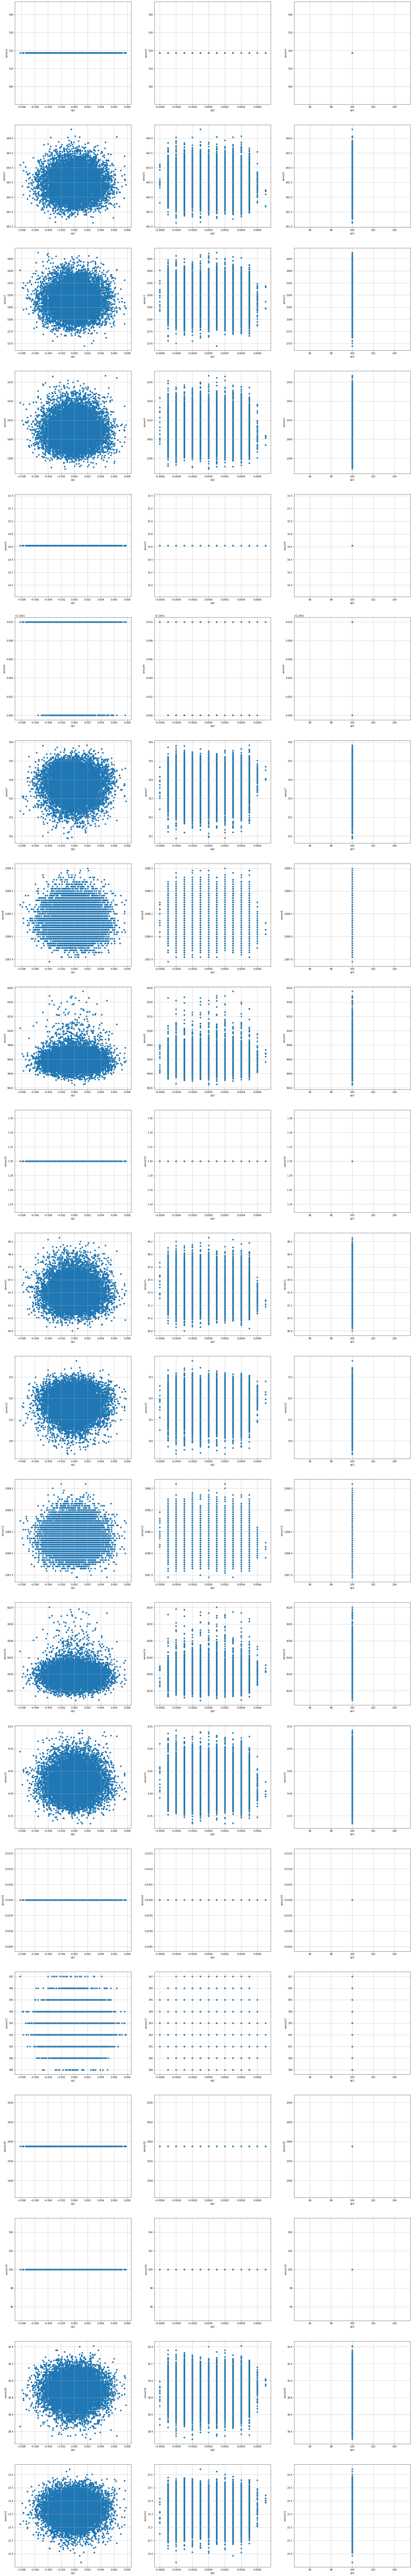

In [21]:
plt.figure(figsize = (30,200))

for i in range(63):
  sub = plt.subplot(21, 3, i +1)
  sub.scatter(test[str(op_set[i % 3])], test[str(sensor[i // 3])])
  sub.set_xlabel(str(op_set[i % 3]))
  sub.set_ylabel(str(sensor[i // 3]))
  sub.grid()


In [22]:
df_train.label.unique()

array([0, 1])

In [23]:
df_test.head(10)

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,remaining_cycle,label
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,21.61,554.22,2388.00,9050.96,1.3,47.26,521.92,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467,137,0
6,1,7,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,14.62,21.61,553.89,2388.05,9051.39,1.3,47.31,522.01,2388.06,8134.97,8.3914,0.03,391,2388,100.0,38.85,23.3952,136,0
7,1,8,0.0006,-0.0000,100.0,518.67,642.54,1580.89,1400.89,14.62,21.61,553.59,2388.05,9052.86,1.3,47.21,522.09,2388.06,8125.93,8.4213,0.03,393,2388,100.0,39.05,23.3224,135,0
8,1,9,-0.0036,0.0000,100.0,518.67,641.88,1593.29,1412.28,14.62,21.61,554.49,2388.06,9048.55,1.3,47.37,522.03,2388.05,8134.15,8.4353,0.03,391,2388,100.0,39.10,23.4521,134,0
9,1,10,-0.0025,-0.0001,100.0,518.67,642.07,1585.25,1398.64,14.62,21.61,554.28,2388.04,9051.95,1.3,47.14,522.00,2388.06,8134.08,8.4093,0.03,391,2388,100.0,38.87,23.3820,133,0


In [24]:
df_test.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19"],axis=1,inplace=True)

In [25]:
x=df_train.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","remaining_cycle","label"],axis=1)
y=df_train.label
print('x shape : ',x.shape)
print('y shape : ',y.shape)

x shape :  (20631, 16)
y shape :  (20631,)


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=3)
# gc.collect()  
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 16)
X_test shape :  (4127, 16)
y_train shape :  (16504,)
y_test shape :  (4127,)


In [27]:
import lightgbm as lgb
lgb_clss = lgb.LGBMClassifier(learning_rate=0.01,n_estimators=5000,num_leaves=100,objective='binary', metrics='auc',random_state=50,n_jobs=-1)
lgb_clss.fit(X_train, y_train)
lgb_clss.score(X_test, y_test)
preds2 = lgb_clss.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, preds2))
print('Roc Auc Score: ',roc_auc_score(y_test, preds2))
print('Precision Score: ',precision_score(y_test, preds2))
print('Recall Score: ',recall_score(y_test, preds2))
print('f1 score: ',f1_score(y_test, preds2,'binary'))

Acc Score:  0.9781923915677248
Roc Auc Score:  0.8961261655542994
Precision Score:  0.7752293577981652
Recall Score:  0.8047619047619048
f1 score:  0.7897196261682244


Text(0.5, 1.0, 'Order by importance')

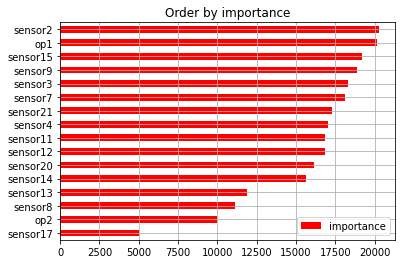

In [28]:
fi_df = pd.DataFrame(lgb_clss.feature_importances_, index = X_train.columns, columns=['importance']).sort_values(by = 'importance', ascending = True)
ax2 = fi_df.plot(kind = 'barh', color = "Red")
ax2.grid()
ax2.set_title('Order by importance')

In [29]:
confusion_matrix(y_test, preds2)

array([[3868,   49],
       [  41,  169]])

In [30]:
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
stf_kf=StratifiedKFold(n_splits=5)
import xgboost as xgb
xgb_classifier=xgb.XGBClassifier(n_estimators=725,n_jobs=-1)
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1), 
         'subsample': np.arange( 0.7, 1, 0.05), 
         'gamma': np.arange(0.5, 1, 0.1), 
         'colsample_bytree': np.arange( 0.1, 1, 0.05), 
         'scale_pos_weight': np.arange( 20, 200, 10)}
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=stf_kf,n_jobs=-1)
rs_cv_classifier.fit(X_train,y_train)
y_pred=rs_cv_classifier.predict(X_test)
print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_pred,y_test))

Best Parameter: 
 {'subsample': 0.8, 'scale_pos_weight': 50, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.060000000000000005, 'gamma': 0.7, 'colsample_bytree': 0.6500000000000001}
XGBClassifier Acc Score:  0.97552701720378


In [31]:
df_test_pred = rs_cv_classifier.predict(df_test.drop(['remaining_cycle','label'],axis=1))
cm=confusion_matrix(df_test.iloc[:,-1], df_test_pred, labels=None, sample_weight=None)

In [32]:
print("Test Accuracy Score: ", accuracy_score(df_test.iloc[:,-1],df_test_pred))

Test Accuracy Score:  0.9983964569334148


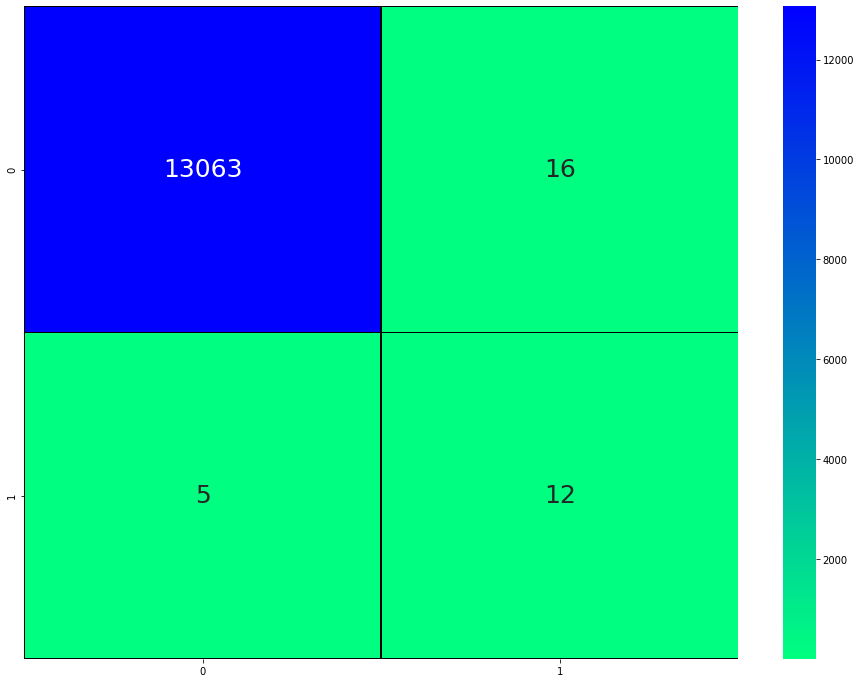

In [33]:
plt.figure(figsize=(16,12))
sb.heatmap(cm,annot=True,annot_kws={"size": 25},linewidths=0.7,linecolor="black",cmap="winter_r",fmt="d")

In [34]:
X_train

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
1771,-0.0030,0.0004,642.14,1589.48,1401.50,554.46,2388.02,9068.72,47.06,522.63,2388.04,8151.81,8.4091,391,39.11,23.4678
17363,-0.0016,-0.0005,642.74,1592.33,1402.50,553.89,2388.10,9062.59,47.47,521.50,2388.09,8139.85,8.4285,394,38.92,23.3893
11502,0.0033,0.0000,642.82,1590.22,1415.22,552.82,2388.13,9062.13,47.56,521.30,2388.16,8131.17,8.4379,395,38.77,23.2111
3886,-0.0042,-0.0004,643.27,1595.25,1419.58,552.76,2388.17,9042.70,47.87,520.88,2388.21,8125.12,8.4634,395,38.80,23.1583
3033,0.0028,0.0004,642.44,1586.94,1398.81,553.79,2388.12,9057.66,47.54,521.41,2388.08,8128.15,8.4322,394,38.89,23.3343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6400,0.0006,0.0003,643.11,1604.94,1423.33,551.72,2388.17,9079.93,48.10,520.41,2388.18,8153.95,8.5034,397,38.61,23.1649
15288,-0.0025,0.0002,643.09,1597.94,1412.81,553.50,2388.16,9050.97,47.61,520.61,2388.15,8131.20,8.4686,393,38.77,23.3200
11513,-0.0036,-0.0002,642.79,1597.51,1411.00,552.52,2388.18,9056.59,47.70,520.45,2388.16,8130.22,8.4651,395,38.79,23.2957
1688,0.0001,0.0005,643.15,1599.98,1420.01,552.09,2388.26,9045.89,47.90,520.26,2388.19,8123.39,8.5094,395,38.51,23.1537


In [35]:
y_train

1771     0
17363    0
11502    0
3886     0
3033     0
        ..
6400     0
15288    0
11513    0
1688     0
5994     0
Name: label, Length: 16504, dtype: int64

In [36]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [37]:
df_train


,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,remaining_cycle,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1


In [38]:
# 양품
TF_Y = df_train[df_train['label']==0]
print('TF의 양품 개수:', len(TF_Y))

# 불량
TF_N = df_train[df_train['label']==1]
print('TF의 불량 개수:', len(TF_N))

TF의 양품 개수: 19531
TF의 불량 개수: 1100


In [39]:
# 양품
TF_Y.drop(['label'] ,axis=1, inplace=True)

# 불량
TF_N.drop(['label'] ,axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 양품
TF_Y = scaler.fit_transform(TF_Y)

# 불량
TF_N = scaler.fit_transform(TF_N)

In [41]:
TF_train_Y = TF_Y[:12000]
TF_test_Y = TF_Y[12000:]
TF_test_N = TF_N

print('CN7의 양품 학습 데이터셋 개수:', len(TF_train_Y))
print('CN7의 양품 검증 데이터셋 개수:', len(TF_test_Y))
print('CN7의 불량 검증 데이터셋 개수:', len(TF_test_N))

CN7의 양품 학습 데이터셋 개수: 12000
CN7의 양품 검증 데이터셋 개수: 7531
CN7의 불량 검증 데이터셋 개수: 1100


In [42]:
dropout_encoder = Sequential([
    Dropout(0.3),
    Dense(15, activation="relu"),
    Dense(5, activation="relu")
])

dropout_decoder = Sequential([
    Dense(15, activation="relu", input_shape=[5]),
    Dense(TF_train_Y.shape[1], activation="relu"),
])

dropout_AE = Sequential([dropout_encoder, dropout_decoder])

In [43]:
# 손실함수 옵티마이저 정의
dropout_AE.compile(loss="mse", optimizer=Adam(lr=0.01), metrics=['accuracy'])
# 모델 훈련
history = dropout_AE.fit(TF_train_Y, TF_train_Y, batch_size=30, epochs=30, validation_split=0.2, callbacks=[EarlyStopping(monitor="val_loss", patience=7, mode="min")])
# 결과는 아래에서 확인 가능하다.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
320/320 [==============================] - 25s 4ms/step - loss: 0.0492 - accuracy: 0.9187 - val_loss: 0.0274 - val_accuracy: 0.9804
Epoch 2/30
320/320 [==============================] - 1s 2ms/step - loss: 0.0194 - accuracy: 0.9691 - val_loss: 0.0208 - val_accuracy: 0.9804
Epoch 3/30
320/320 [==============================] - 1s 2ms/step - loss: 0.0113 - accuracy: 0.9701 - val_loss: 0.0117 - val_accuracy: 0.9804
Epoch 4/30
320/320 [==============================] - 1s 2ms/step - loss: 0.0089 - accuracy: 0.9718 - val_loss: 0.0105 - val_accuracy: 0.9804
Epoch 5/30
320/320 [==============================] - 1s 2ms/step - loss: 0.0087 - accuracy: 0.9678 - val_loss: 0.0118 - val_accuracy: 0.9804
Epoch 6/30
320/320 [==============================] - 1s 2ms/step - loss: 0.0085 - accuracy: 0.9723 - val_loss: 0.0124 - val_accuracy: 0.9804
Epoch 7/30
320/320 [==============================] - 1s 2ms/step - loss: 0.0085 - accuracy: 0.9728 - val_loss: 0.0110 - val_accuracy: 0.9804
Epoch

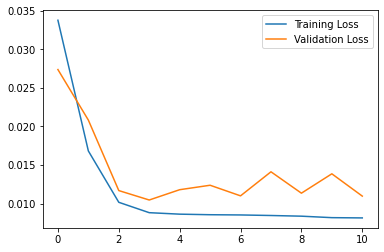

In [44]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
# plt.savefig('loss.png', dpi=300)
plt.show()

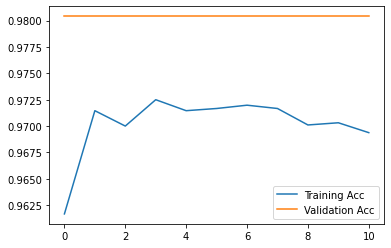

In [45]:
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend()
plt.savefig('acc.png', dpi=300)
plt.show()

In [46]:
# 학습 데이터의 예측값

TF_train_pred = dropout_AE.predict(TF_train_Y)
# 학습 데이터의 복원 오차 (예측값 – 실제 값)
TF_train_loss = np.mean(np.square(TF_train_pred - TF_train_Y), axis=1)

# 임계치
threshold = np.mean(TF_train_loss)  + 5*np.std(TF_train_loss)

print("복원 오류 임계치: ", threshold) #결과는 아래에서 확인 가능하다.

복원 오류 임계치:  0.03838237685868882


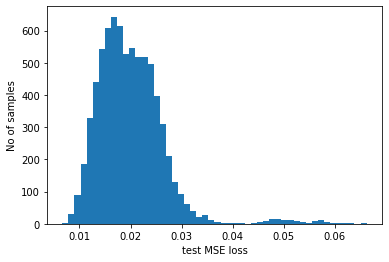

불량 개수:  132


In [47]:
# 평가 데이터의 양품

# 예측값
TF_predict_Y = dropout_AE.predict(TF_test_Y)

# 양품 평가 데이터의 복원 오차 (예측값 – 실제 값)
TF_test_Y_mse= np.mean(np.square(TF_predict_Y - TF_test_Y), axis=1)

# 시각화
plt.hist(TF_test_Y_mse, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show() 

# 불량으로 판단한 데이터 확인
TF_test_Y_anomalies = TF_test_Y_mse > threshold
print("불량 개수: ", np.sum(TF_test_Y_anomalies)) #결과는 아래에서 확인 가능하다.

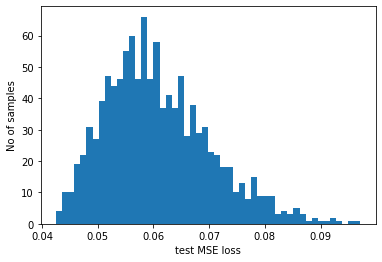

불량 개수:  1100


In [48]:
# 평가 데이터의 불량

# 예측값
TF_predict_N = dropout_AE.predict(TF_test_N)
# 불량 평가 데이터의 복원 오차 (예측값 – 실제 값)
TF_test_N_mse = np.mean(np.square(TF_predict_N - TF_test_N), axis=1)

# 시각화
plt.hist(TF_test_N_mse, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show() 

# 불량으로 판단한 데이터 확인
TF_test_N_anomalies = TF_test_N_mse > threshold
print("불량 개수: ", np.sum(TF_test_N_anomalies)) #결과는 아래에서 확인 가능하다.

In [49]:
TF_true = np.concatenate([np.zeros(len(TF_test_Y_anomalies)), np.ones(len(TF_test_N_anomalies))])

In [50]:
TF_prediction = np.concatenate([TF_test_Y_anomalies, TF_test_N_anomalies])

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(TF_true, TF_prediction)  #결과는 아래에서 확인 가능하다.

array([[7399,  132],
       [   0, 1100]])

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("정확도:", accuracy_score(TF_true, TF_prediction))
print("정밀도:", precision_score(TF_true, TF_prediction))
print("재현율:", recall_score(TF_true, TF_prediction))
print("F1:",f1_score(TF_true, TF_prediction)) #결과는 아래에서 확인 가능하다.

정확도: 0.9847062912756344
정밀도: 0.8928571428571429
재현율: 1.0
F1: 0.9433962264150945
